## Step 1: Download data

- To run these examples you need an example LFP NWB file. Below is the first session used in one of the allensdk tutorials. These are the 6 files (one probe per file).

In [18]:
%load_ext autoreload
%autoreload 2
import hvneuro
import os
from numcodecs import Blosc
import h5py
import numpy as np
import shutil
import zarr
import dask.array as da
import xarray as xr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
files_to_download = {
    "http://api.brain-map.org/api/v2/well_known_file_download/1026124481": "probe_810755797_lfp.nwb",
    # "http://api.brain-map.org/api/v2/well_known_file_download/1026124479": "probe_810755799_lfp.nwb",
    # "http://api.brain-map.org/api/v2/well_known_file_download/1026124471": "probe_810755801_lfp.nwb",
    # "http://api.brain-map.org/api/v2/well_known_file_download/1026124473": "probe_810755803_lfp.nwb",
    # "http://api.brain-map.org/api/v2/well_known_file_download/1026124475": "probe_810755805_lfp.nwb",
    # "http://api.brain-map.org/api/v2/well_known_file_download/1026124477": "probe_810755807_lfp.nwb",
}

In [20]:
data_dir='~/data/allen/'
data_dir = os.path.expanduser(data_dir)
hvneuro.download_files(files_to_download, data_dir=data_dir)

/Users/droumis/data/allen/probe_810755797_lfp.nwb already exists. Skipping download.


## Step 1.5 look at nwb file

In [21]:
probe_id = "810755797"
input_filepath = os.path.join(data_dir, f"probe_{probe_id}_lfp.nwb")

In [7]:
with h5py.File(input_filepath, "r") as f:
    def print_attrs(name, obj):
        print(name)
        for key, val in obj.attrs.items():
            print(f"    {key}: {val}")

    f.visititems(print_attrs)

acquisition
acquisition/probe_810755797_lfp
    namespace: core
    neurodata_type: LFP
    object_id: c5915301-3a3b-4960-83c7-94fbda10bb14
acquisition/probe_810755797_lfp/probe_810755797_lfp_data
    comments: no comments
    description: no description
    namespace: core
    neurodata_type: ElectricalSeries
    object_id: fe8f91e8-7753-417c-8ad2-28bd6714d057
acquisition/probe_810755797_lfp/probe_810755797_lfp_data/data
    conversion: 1.0
    resolution: -1.0
    unit: volts
acquisition/probe_810755797_lfp/probe_810755797_lfp_data/electrodes
    description: lfp channels on probe 810755797
    namespace: hdmf-common
    neurodata_type: DynamicTableRegion
    object_id: ed741d53-bba2-4488-8bfc-fdf94d7aaab2
    table: <HDF5 object reference>
acquisition/probe_810755797_lfp/probe_810755797_lfp_data/timestamps
    interval: 1
    unit: seconds
analysis
file_create_date
general
general/devices
general/devices/probeA
    namespace: ndx-aibs-ecephys
    neurodata_type: EcephysProbe
    obj

## Step 2: Create a new Zarr file with the LFP data
- working from create_zarr_lfp_one_probe.py
- Define a function to create the Zarr file with the specified shape, chunking, and compression settings.
- Read the LFP, electrode, and time data from the NWB file and create a new Zarr file.

### Approach 3. using xarray.to_zarr with chunked load and save 
This approach uses xr.to_zarr to save rather than zarr API, and also tries to load/save in a chunked manner to avoid loading in all the data at once.. although I'm not fully confident that it's doing that.

- Previous approaches are moved to `#scratch` at bottom.
- expose forced rechunking
- return xr.Dataset
- get channels (electrodes) directly from dataset
- get electrode positions and location info
- get subject info
- TODO: add switch for overwriting zarr dir
- Should I really be saving all the electrode info as coords or should they be separate arrays in the dataset?

In [8]:
def get_dataset_str(f, key):
    try:
        return f[key].asstr()[()]
    except KeyError:
        return None

def create_zarr_file_approach3(probe_id: str, data_dir: str, compress_data: bool = False, chunk_size: tuple = (1_000_000, 20), force_rechunk: bool = True):
    """
    Create a Zarr directory containing a single probe's data, chunked and optionally compressed.

    Parameters
    ----------
    probe_id : str
        The probe ID used to identify the specific probe.
    data_dir : str
        The base data directory where the input and output files are located.
    compress_data : bool, optional
        Whether to compress the LFP data. Compression reduces file size at the cost of additional computation.
        Defaults to False.
    chunk_size : tuple, optional
        The size of chunks for the LFP data. Defaults to (1_000_000, 20) : (time_samples, channels).
    force_rechunk : bool, optional
        Whether to force rechunking with the provided chunk size, even if the HDF5 dataset is already chunked.
        Defaults to True.

    Returns
    -------
    ds : xr.Dataset
        An Xarray Dataset object containing the LFP data and associated coordinates. The actual LFP data is not loaded into
        memory until explicitly accessed.
    """

    input_filepath = os.path.join(data_dir, f"probe_{probe_id}_lfp.nwb")
    output_filepath = os.path.join(data_dir, f"lfp_{probe_id}.zarr")

    with h5py.File(input_filepath, "r") as f:       
        lfp_dataset = f[f"acquisition/probe_{probe_id}_lfp/probe_{probe_id}_lfp_data/data"]
        time_dataset = f[f"acquisition/probe_{probe_id}_lfp/probe_{probe_id}_lfp_data/timestamps"]
        electrodes_dataset = f[f"acquisition/probe_{probe_id}_lfp/probe_{probe_id}_lfp_data/electrodes"][:]
        unit_attributes = {
            "time_unit": time_dataset.attrs.get("unit", None),
            "lfp_unit": lfp_dataset.attrs.get("unit", None),
        }
        subject_info = {k:v.asstr()[()] for k, v in f["general/subject"].items()}
        reference_time = get_dataset_str(f, "timestamps_reference_time")
        session_description = get_dataset_str(f, "session_description")

        electrodes_table = f["general/extracellular_ephys/electrodes"]
        electrode_metadata = {}
        for col_name in electrodes_table.keys():
            col_data = electrodes_table[col_name]
            
            # Skip columns with HDF5 object references ("group")
            if h5py.check_ref_dtype(col_data.dtype):
                continue
    
            col_data_array = col_data[:]
            if h5py.check_string_dtype(col_data.dtype):
                electrode_metadata[col_name] = col_data.asstr()[()]
            # xarray is not liking nan type in ("imp")
            elif np.issubdtype(col_data_array.dtype, np.number) and np.isnan(col_data_array).all():
                continue
            else:
                electrode_metadata[col_name] = col_data_array

        # if force_rechunk, use chunk_size.
        # Else, if the hdf5 has chunk info, use that; if not, use chunk_size.
        chunk_shape = chunk_size if force_rechunk else (lfp_dataset.chunks or chunk_size)
        print(f'Chunking with {chunk_shape}')
        
        # Read data in chunks and concat into a Dask array (first across channels then time)
        arrays = []
        for start_time in range(0, lfp_dataset.shape[0], chunk_shape[0]):
            time_slice = slice(start_time, start_time + chunk_shape[0])
            arrays_time = [da.from_array(lfp_dataset[time_slice, slice(start_channel, start_channel + chunk_shape[1])], chunks=chunk_shape)
                           for start_channel in range(0, lfp_dataset.shape[1], chunk_shape[1])]
            arrays.append(da.concatenate(arrays_time, axis=1))
        lfp_dask_array = da.concatenate(arrays, axis=0)
        
        time = time_dataset[:] # load in all the time, shouldn't be too big

    ds = xr.Dataset(
        {
            "lfp": (["time", "channel"], lfp_dask_array, unit_attributes),
        },
        coords={
            "time": time,
            "channel": electrodes_dataset,
            **electrode_metadata,
        },
        attrs={
            "unit_attributes": unit_attributes,
            "reference_time": reference_time,
            "session_description": session_description,
            "subject_info" : subject_info
        }
    )

    if os.path.isdir(output_filepath):
        shutil.rmtree(output_filepath)

    compressor = Blosc(cname='zstd', clevel=3, shuffle=Blosc.BITSHUFFLE) if compress_data else None
    ds.to_zarr(output_filepath, encoding={'lfp': {'compressor': compressor}})

    print(f"Zarr file for probe {probe_id} has been created successfully at {output_filepath}.")

    return ds

In [9]:
%%time
lfp_data = create_zarr_file_approach3(probe_id=probe_id, data_dir=data_dir, force_rechunk=True)

Chunking with (1000000, 20)
Zarr file for probe 810755797 has been created successfully at /Users/droumis/data/allen/lfp_810755797.zarr.
CPU times: user 23 s, sys: 2.53 s, total: 25.6 s
Wall time: 25.9 s


- native chunking of (41859, 1) ~ 25.9 s
- forced rechunking of (1000000, 20) ~ 22.4 s (not sure why this seems to be a bit faster sometimes.. but I'll take it)

In [10]:
lfp_data

<xarray.Dataset>
Dimensions:                    (time: 10715666, channel: 93, filtering: 93,
                                group_name: 93, id: 93, local_index: 93,
                                location: 93, probe_horizontal_position: 93,
                                probe_id: 93, probe_vertical_position: 93,
                                valid_data: 93, x: 93, y: 93, z: 93)
Coordinates: (12/14)
  * time                       (time) float64 28.82 28.82 ... 9.616e+03
  * channel                    (channel) int64 0 1 2 3 4 5 ... 87 88 89 90 91 92
  * filtering                  (filtering) object 'AP band: 500 Hz high-pass;...
  * group_name                 (group_name) object 'probeA' ... 'probeA'
  * id                         (id) int64 850264150 850264158 ... 850264886
  * local_index                (local_index) int64 2 6 10 14 ... 358 362 366 370
    ...                         ...
  * probe_id                   (probe_id) int64 810755797 ... 810755797
  * probe_vertical_position    (probe_vertical_position) int64 40 80 ... 3720
  * valid_data                 (valid_data) bool True True True ... True True
  * x                          (x) float64 8.164e+03 8.154e+03 ... 7.125e+03
  * y                          (y) float64 3.547e+03 3.513e+03 ... 20.0 -12.0
  * z                          (z) float64 3.547e+03 3.513e+03 ... 20.0 -12.0
Data variables:
    lfp                        (time, channel) float32 dask.array<chunksize=(1000000, 20), meta=np.ndarray>
Attributes:
    unit_attributes:      {'time_unit': 'seconds', 'lfp_unit': 'volts'}
    reference_time:       2019-01-19T00:54:18-08:00
    session_description:  LFP data and associated channel info for a single E...
    subject_info:         {'age': 'P118D', 'genotype': 'Sst-IRES-Cre/wt;Ai32(...

In [11]:
lfp_data.lfp

<xarray.DataArray 'lfp' (time: 10715666, channel: 93)>
dask.array<concatenate, shape=(10715666, 93), dtype=float32, chunksize=(1000000, 20), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 28.82 28.82 28.83 ... 9.616e+03 9.616e+03 9.616e+03
  * channel  (channel) int64 0 1 2 3 4 5 6 7 8 9 ... 84 85 86 87 88 89 90 91 92
Attributes:
    time_unit:  seconds
    lfp_unit:   volts

## Step 3: Plot LFP Data w Matplotlib
- (test_zarr_lfp_one_probe.py)
- Plot the LFP data for a subset of time and channels to visualize the signal.

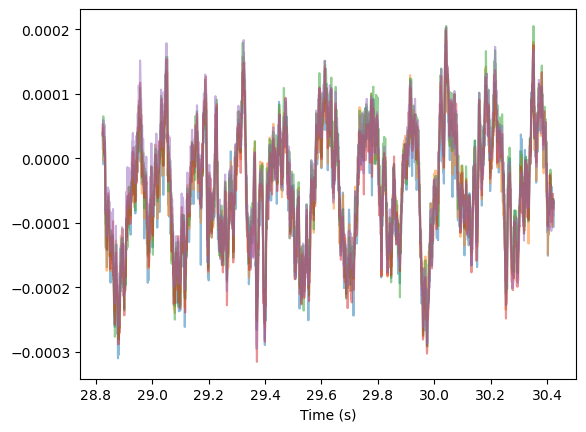

In [12]:
import matplotlib.pyplot as plt

output_filepath = os.path.join(data_dir, f"lfp_{probe_id}.zarr")

# Disable mask_and_scale otherwise dtypes are converted to floats.
ds = xr.open_zarr(output_filepath, mask_and_scale=False, consolidated=False)

data = ds.lfp[:, 10:30]
data = ds.lfp

mean = data.mean(axis=0).compute()
# print("mean", mean)

fig, ax = plt.subplots()
time = ds.time[:2000]
lfp = ds.lfp[:2000, :5]
ax.plot(time, lfp, alpha=0.5)

ax.set_xlabel("Time (s)")
plt.show()


## Step 4: Plot LFP Data with Bokeh

- Use the real channel/electrode names 

In [13]:
import xarray as xr
from bokeh.plotting import figure
from bokeh.models import HoverTool, Range1d, ColumnDataSource
from bokeh.io import show, output_notebook

output_notebook()

output_filepath = os.path.join(data_dir, f"lfp_{probe_id}.zarr")

# Disable mask_and_scale otherwise dtypes are converted to floats.
ds = xr.open_zarr(output_filepath, mask_and_scale=False, consolidated=False)

Loading BokehJS ...

In [14]:
ds.lfp

<xarray.DataArray 'lfp' (time: 10715666, channel: 93)>
dask.array<open_dataset-lfp, shape=(10715666, 93), dtype=float32, chunksize=(1000000, 20), chunktype=numpy.ndarray>
Coordinates:
  * channel  (channel) int64 0 1 2 3 4 5 6 7 8 9 ... 84 85 86 87 88 89 90 91 92
  * time     (time) float64 28.82 28.82 28.83 ... 9.616e+03 9.616e+03 9.616e+03
Attributes:
    lfp_unit:    volts
    time_unit:   seconds
    _FillValue:  nan

In [15]:
# # get the first chunk of data
# time = ds.lfp.time.data[:ds.lfp.chunks[0][0]]
# channels = ds.lfp.channel.data.astype(str)[:ds.lfp.chunks[1][0]]
# data = lfp_data[:ds.lfp.chunks[0][0], :ds.lfp.chunks[1][0]].compute().data.T

In [16]:
# Actually, plot an even smaller subset of the data
crop_t = 100
crop_c = 20
time = ds.lfp.time.data[:crop_t]
channels = ds.lfp.channel.data.astype(str)[:crop_c]
data = ds.lfp[:crop_t, :crop_c].compute().data.T

In [17]:
from bokeh.models import FactorRange
from bokeh.core.properties import field

hover = HoverTool(tooltips=[
    ("Channel", "$name"),
    ("Time", "$x s"),
    ("Amplitude", "$y V"),
])

x_range = Range1d(start=time.min(), end=time.max())
y_range = FactorRange(factors=channels)

p = figure(x_range=x_range, y_range=y_range, active_scroll="wheel_zoom", lod_threshold=None)
p.add_tools(hover)

source = ColumnDataSource(data=dict(time=time))

for i, channel in enumerate(channels):
    xy = p.subplot(
        x_source=p.x_range,
        y_source=Range1d(start=data[i].min(), end=data[i].max()),
        x_target=p.x_range,
        y_target=Range1d(start=i, end=i + 1),
    )

    source.data[channel] = data[i]
    line = xy.line(field("time"), field(channel), color="black", source=source, name=channel)

show(p)

Now we need to figure out how to efficiently access/visualize **all** the data

# Scratch (ignore)

### Approach 1: using Zarr's native writing
- return zarr.core.Array

In [48]:
def create_zarr_file_approach1(probe_id: str, data_dir: str, compress_data: bool = False, chunk_size: tuple = (1_000_000, 20)):

    input_filepath = os.path.join(data_dir, f"probe_{probe_id}_lfp.nwb")
    output_filepath = os.path.join(data_dir, f"lfp_{probe_id}.zarr")

    f = h5py.File(input_filepath, "r")

    time = f[f"acquisition/probe_{probe_id}_lfp/probe_{probe_id}_lfp_data/timestamps"]
    lfp = f[f"acquisition/probe_{probe_id}_lfp/probe_{probe_id}_lfp_data/data"]
    nchannel = lfp.shape[1]

    if os.path.isdir(output_filepath):
        shutil.rmtree(output_filepath)

    root = zarr.group(output_filepath)

    if compress_data:
        compressor = Blosc(cname='zstd', clevel=3, shuffle=Blosc.BITSHUFFLE)
    else:
        compressor = None

    lfp_data = root.create_dataset("lfp",
        shape=(len(time), nchannel),
        synchronizer=zarr.ThreadSynchronizer(),
        chunks=(1_000_000, 20),
        compressor=compressor,
        dtype=lfp.dtype,
    )
    lfp_data.attrs["_ARRAY_DIMENSIONS"] = ["time", "channel"]

    coord = zarr.open_array(
        os.path.join(output_filepath, "time"),
        mode="w",
        shape=time.shape,
        dtype=time.dtype,
    )
    coord[:] = time
    coord.attrs["_ARRAY_DIMENSIONS"] = ["time"]

    channel = np.arange(nchannel, dtype=np.uint32)
    coord = zarr.open_array(
        os.path.join(output_filepath, "channel"),
        mode="w",
        shape=channel.shape,
        dtype=channel.dtype,
    )
    coord[:] = channel
    coord.attrs["_ARRAY_DIMENSIONS"] = ["channel"]

    print(f"Storing LFP data from {input_filepath} to {output_filepath}")
    lfp_data[:] = lfp[:]

    print(f"Zarr file for probe {probe_id} has been created successfully at {output_filepath}.")
    return lfp_data


### Approach 2: using xarray.to_zarr with forced rechunking

- return xr.Dataset

In [17]:
def create_zarr_file_approach2(probe_id: str, data_dir: str, compress_data: bool = False, chunk_size: tuple = (1_000_000, 20)):

    input_filepath = os.path.join(data_dir, f"probe_{probe_id}_lfp.nwb")
    output_filepath = os.path.join(data_dir, f"lfp_{probe_id}.zarr")
    
    f = h5py.File(input_filepath, "r")

    # I think this will load in all the data
    time = f[f"acquisition/probe_{probe_id}_lfp/probe_{probe_id}_lfp_data/timestamps"][:]
    lfp = f[f"acquisition/probe_{probe_id}_lfp/probe_{probe_id}_lfp_data/data"][:]
    channel = np.arange(lfp.shape[1], dtype=np.uint32)

    ds = xr.Dataset(
        {
            "lfp": (["time", "channel"], lfp),
        },
        coords={
            "time": time,
            "channel": channel,
        },
    )

    ds = ds.chunk({'time': chunk_size[0], 'channel': chunk_size[1]})

    if os.path.isdir(output_filepath):
        shutil.rmtree(output_filepath)

    ds.to_zarr(output_filepath, encoding={'lfp': {'compressor': compressor}})

    print(f"Zarr file for probe {probe_id} has been created successfully at {output_filepath}.")

    return ds

In [52]:
%%time
lfp_data = create_zarr_file_approach1(probe_id=probe_id, data_dir=data_dir)

Storing LFP data from /Users/droumis/data/allen/probe_810755797_lfp.nwb to /Users/droumis/data/allen/lfp_810755797.zarr
Zarr file for probe 810755797 has been created successfully at /Users/droumis/data/allen/lfp_810755797.zarr.
CPU times: user 21.7 s, sys: 2.58 s, total: 24.3 s
Wall time: 25.6 s


25.5 s

In [50]:
%%time
lfp_data = create_zarr_file_approach2(probe_id=probe_id, data_dir=data_dir)

Zarr file for probe 810755797 has been created successfully at /Users/droumis/data/allen/lfp_810755797.zarr.
CPU times: user 29.2 s, sys: 6.28 s, total: 35.4 s
Wall time: 26.7 s


26.7 s